# GAN Training Challenges: DCGAN for Color Images

This is a project that I started to see if I could train an AI to generate abstact art. I found much of this code from Margaret Maynard-Reid (@margaretmz) and I do not claim to own all of this code, this project was done purely for my own curiousity! I have always found image generation cool and I wanted to see how well an AI could generate different kinds of art!

I found my dataset on [Kaggle](https://www.kaggle.com/datasets/bryanb/abstract-art-gallery). The dataset contains 2782 files of abstract images and was posted by bryanb.

## Import

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np

import os

Its always a good practice to check the current version of TensorFlow...

In [ ]:
print(tf.version.VERSION)

2.7.0


## Data

We will train the DCGAN on a dataset called [best-artworks-of-all-time](https://www.kaggle.com/datasets/bryanb/abstract-art-gallery) from Kaggle, which is a collection of abstract art, scraped from https://www.wikiart.org/. 

Here is how to download Kaggle data from Colab:
* Navigate to https://www.kaggle.com. 
* Go to the [account tab](https://www.kaggle.com/me/account)  of your user profile. 
* Select "Create API Token" which triggers the download of kaggle.json, a file containing your API credentials. 
* Enter your username and Kaggle key in the cell below.

In [ ]:
os.environ['KAGGLE_USERNAME']="benporter165" 
os.environ['KAGGLE_KEY']="4350c82c1aef6c1bdc09cbf1b65327aa"

In [ ]:
# download kaggle dataset to 'datasets/' path
!kaggle datasets download -d ikarus777/best-artworks-of-all-time -p datasets

100% 2.29G/2.29G [00:50<00:00, 32.9MB/s]
100% 2.29G/2.29G [00:51<00:00, 48.2MB/s]


In [ ]:
!unzip datasets/best-artworks-of-all-time -d datasets/

Streaming output truncated to the last 5000 lines.
  inflating: datasets/resized/resized/Henri_Rousseau_61.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_62.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_63.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_64.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_65.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_66.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_67.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_68.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_69.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_7.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_70.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_8.jpg  
  inflating: datasets/resized/resized/Henri_Rousseau_9.jpg  
  inflating: datasets/resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: datasets/resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
 

In [ ]:
Abstract_gallery_dir = "/content/datasets/images"

In [ ]:
train_images = tf.keras.utils.image_dataset_from_directory(
    Abstract_gallery_dir, label_mode=None, image_size=(64, 64), batch_size=32
)

Found 8774 files belonging to 1 classes.


### Visualization

Here is a visualization of the training data to get an idea of what the images look like. 

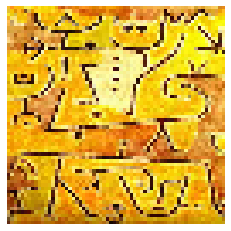

In [ ]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

### Preprocessing

In [ ]:
# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

## The Generator

Define the generator model architecture with the Keras `Sequential` API.

Use `ReLU` except for the last layer which has `tanh` as the activation.

The job of the generator is to make images, to do so in DCGAN, we feed random noise as input to the generator and upsample till the desired image size becomes 64x64x3.

In [ ]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 3 # UPDATED from 1

In [ ]:
def build_generator():
    # create a Keras Sequential model 
    model = Sequential(name='generator')

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    # model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # layers.LeakyReLU(alpha=0.2),

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((8, 8, 512)))

    # upsample to 16x16: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 32x32: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 64x64: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    # model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    # return the generator model
    return model

In [ ]:
# build the generator model
generator = build_generator() 

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

## The Discriminator

Define the discriminator model architecture with the Keras `Sequential` API

In [ ]:
def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    # 1. first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 2. second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # 3. third set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputting a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    # return the discriminator model
    return model

In [ ]:
# build the discriminator model
discriminator = build_discriminator(64, 64, 3) 

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

## DCGAN

### Define the DCGAN class
Subclass `keras.Model` and override `train_step()` to implement the DCGAN architecture. This is where the magic happens and the heart of the DCGAN implementation.

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            # UPDATED: apply one-sided label smoothing to real labels
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            # UPDATED: add random noise to fake labels - not needed
            # fake_labels += 0.05 * tf.random.uniform(tf.shape(fake_labels)) 
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        misleading_labels = tf.ones((batch_size, 1)) # G wants D to think the fake images are real (label as 1)

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator wieghts
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

### Use Keras Callback to monitor training

The nice thing about overriding `train_step()` of `keras.Model()` is that we can subclass `Callback` to monitor our DCGAN training.

I use the seed noise to create images (with the generator model) throughout the training to see the progress of the generator is making. Also saved the generator model at the end of the training which could potentially be used for inference later.

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during traing
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img)
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

### The DCGAN model - putting it together

In [ ]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

## Compile DCGAN

Compile the dcgan model, use the `Adam` optimizer, learning rate of 0.0002, and the **Binary Cross Entropy**.

In [ ]:
D_LR = 0.0001 # UPDATED: discriminator learning rate
G_LR = 0.0003 # UPDATED: generator learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

## Train DCGAN
Now we simply call `model.fit()` to traing the dcgan model!

Epoch 1/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7023 - g_loss: 0.6890

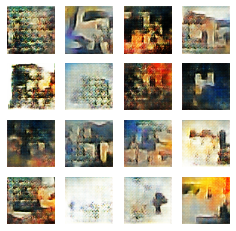

275/275 [==============================] - 53s 187ms/step - d_loss: 0.7021 - g_loss: 0.6895
Epoch 2/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7026 - g_loss: 0.6878

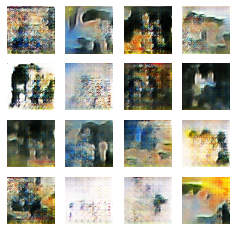

275/275 [==============================] - 53s 190ms/step - d_loss: 0.7026 - g_loss: 0.6878
Epoch 3/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7029 - g_loss: 0.6858

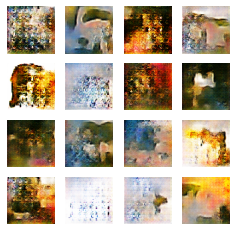

275/275 [==============================] - 55s 195ms/step - d_loss: 0.7029 - g_loss: 0.6858
Epoch 4/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7024 - g_loss: 0.6863

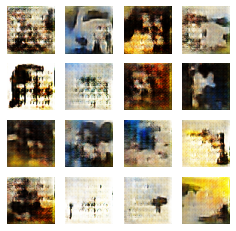

275/275 [==============================] - 54s 192ms/step - d_loss: 0.7025 - g_loss: 0.6865
Epoch 5/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7021 - g_loss: 0.6863

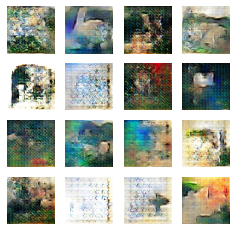

275/275 [==============================] - 56s 200ms/step - d_loss: 0.7022 - g_loss: 0.6862
Epoch 6/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7011 - g_loss: 0.6868

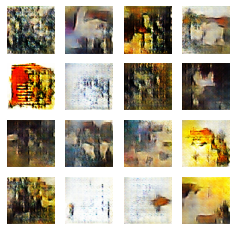

275/275 [==============================] - 55s 197ms/step - d_loss: 0.7011 - g_loss: 0.6870
Epoch 7/50
275/275 [==============================] - ETA: 0s - d_loss: 0.7008 - g_loss: 0.6863

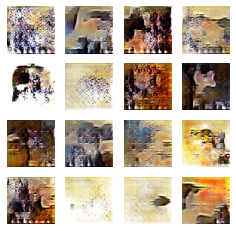

275/275 [==============================] - 56s 198ms/step - d_loss: 0.7008 - g_loss: 0.6863
Epoch 8/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7015 - g_loss: 0.6871

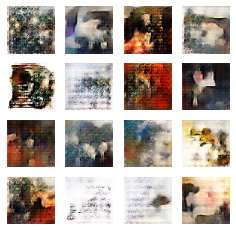

275/275 [==============================] - 56s 198ms/step - d_loss: 0.7017 - g_loss: 0.6873
Epoch 9/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7015 - g_loss: 0.6873

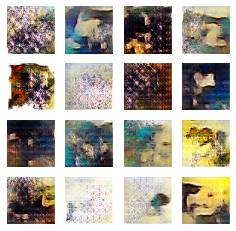

275/275 [==============================] - 56s 200ms/step - d_loss: 0.7016 - g_loss: 0.6877
Epoch 10/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7005 - g_loss: 0.6845

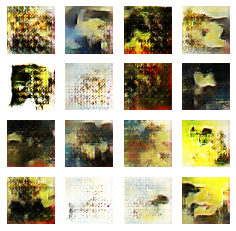

275/275 [==============================] - 58s 205ms/step - d_loss: 0.7006 - g_loss: 0.6846
Epoch 11/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7017 - g_loss: 0.6852

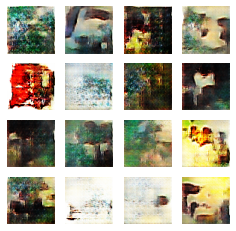

275/275 [==============================] - 57s 201ms/step - d_loss: 0.7019 - g_loss: 0.6853
Epoch 12/50
275/275 [==============================] - ETA: 0s - d_loss: 0.7003 - g_loss: 0.6860

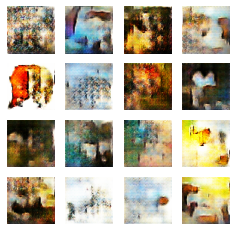

275/275 [==============================] - 57s 204ms/step - d_loss: 0.7003 - g_loss: 0.6860
Epoch 13/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7010 - g_loss: 0.6866

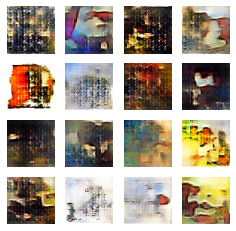

275/275 [==============================] - 58s 205ms/step - d_loss: 0.7012 - g_loss: 0.6872
Epoch 14/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7010 - g_loss: 0.6854

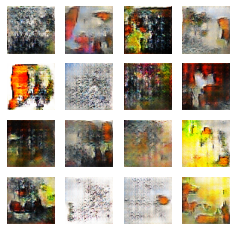

275/275 [==============================] - 58s 205ms/step - d_loss: 0.7010 - g_loss: 0.6853
Epoch 15/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.7001 - g_loss: 0.6868

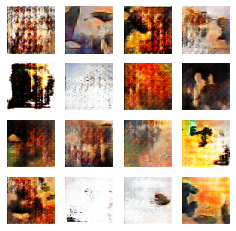

275/275 [==============================] - 58s 207ms/step - d_loss: 0.7001 - g_loss: 0.6868
Epoch 16/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6991 - g_loss: 0.6871

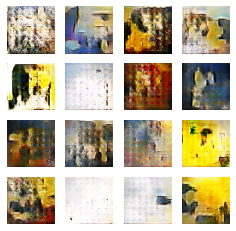

275/275 [==============================] - 58s 204ms/step - d_loss: 0.6989 - g_loss: 0.6872
Epoch 17/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6987 - g_loss: 0.6957

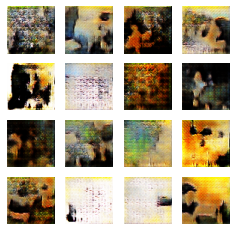

275/275 [==============================] - 58s 206ms/step - d_loss: 0.6988 - g_loss: 0.6958
Epoch 18/50
275/275 [==============================] - ETA: 0s - d_loss: 0.6980 - g_loss: 0.6897

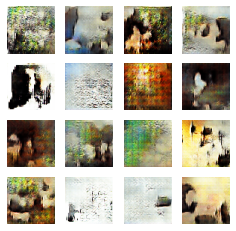

275/275 [==============================] - 59s 210ms/step - d_loss: 0.6980 - g_loss: 0.6897
Epoch 19/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6963 - g_loss: 0.6962

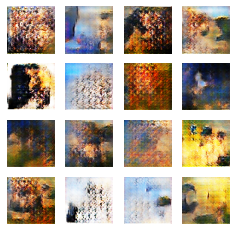

275/275 [==============================] - 60s 214ms/step - d_loss: 0.6965 - g_loss: 0.6964
Epoch 20/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6997 - g_loss: 0.6911

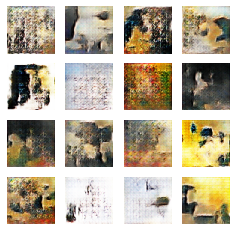

275/275 [==============================] - 60s 212ms/step - d_loss: 0.6998 - g_loss: 0.6910
Epoch 21/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6977 - g_loss: 0.6890

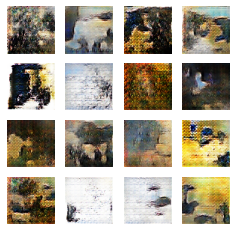

275/275 [==============================] - 60s 213ms/step - d_loss: 0.6976 - g_loss: 0.6893
Epoch 22/50
275/275 [==============================] - ETA: 0s - d_loss: 0.6990 - g_loss: 0.6914

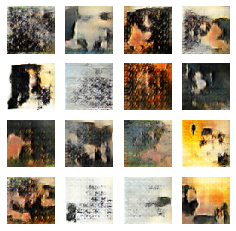

275/275 [==============================] - 61s 216ms/step - d_loss: 0.6990 - g_loss: 0.6914
Epoch 23/50
275/275 [==============================] - ETA: 0s - d_loss: 0.6993 - g_loss: 0.6870

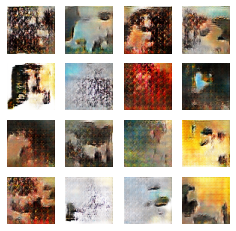

275/275 [==============================] - 60s 214ms/step - d_loss: 0.6993 - g_loss: 0.6870
Epoch 24/50
275/275 [==============================] - ETA: 0s - d_loss: 0.6973 - g_loss: 0.6895

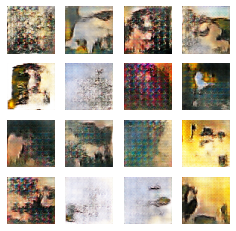

275/275 [==============================] - 61s 217ms/step - d_loss: 0.6973 - g_loss: 0.6895
Epoch 25/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6971 - g_loss: 0.6932

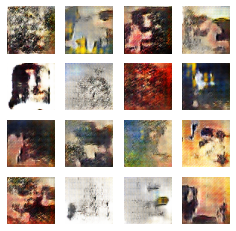

275/275 [==============================] - 60s 215ms/step - d_loss: 0.6973 - g_loss: 0.6935
Epoch 26/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6971 - g_loss: 0.6929

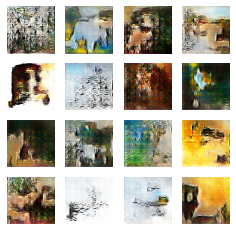

275/275 [==============================] - 61s 218ms/step - d_loss: 0.6973 - g_loss: 0.6929
Epoch 27/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6966 - g_loss: 0.6900

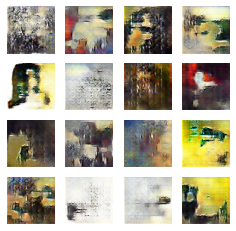

275/275 [==============================] - 61s 218ms/step - d_loss: 0.6967 - g_loss: 0.6903
Epoch 28/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6977 - g_loss: 0.6955

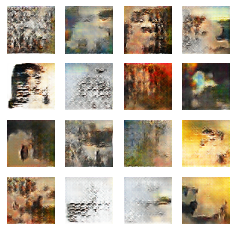

275/275 [==============================] - 64s 226ms/step - d_loss: 0.6975 - g_loss: 0.6960
Epoch 29/50
275/275 [==============================] - ETA: 0s - d_loss: 0.6953 - g_loss: 0.6911

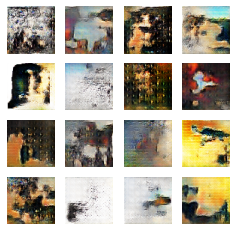

275/275 [==============================] - 63s 224ms/step - d_loss: 0.6953 - g_loss: 0.6911
Epoch 30/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6972 - g_loss: 0.6922

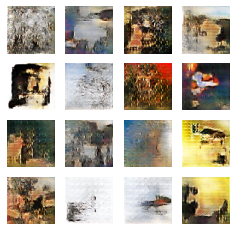

275/275 [==============================] - 62s 221ms/step - d_loss: 0.6973 - g_loss: 0.6923
Epoch 31/50
275/275 [==============================] - ETA: 0s - d_loss: 0.6947 - g_loss: 0.6966

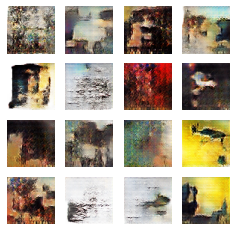

275/275 [==============================] - 70s 250ms/step - d_loss: 0.6947 - g_loss: 0.6966
Epoch 32/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6943 - g_loss: 0.6986

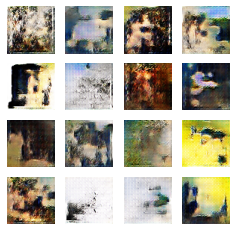

275/275 [==============================] - 63s 224ms/step - d_loss: 0.6944 - g_loss: 0.6990
Epoch 33/50
275/275 [==============================] - ETA: 0s - d_loss: 0.6936 - g_loss: 0.7007

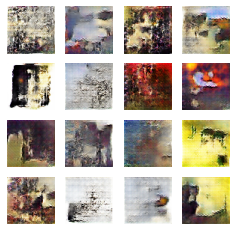

275/275 [==============================] - 63s 223ms/step - d_loss: 0.6936 - g_loss: 0.7007
Epoch 34/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6971 - g_loss: 0.6965

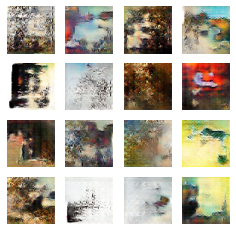

275/275 [==============================] - 62s 222ms/step - d_loss: 0.6973 - g_loss: 0.6967
Epoch 35/50
275/275 [==============================] - ETA: 0s - d_loss: 0.6958 - g_loss: 0.6952

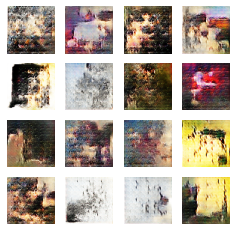

275/275 [==============================] - 63s 226ms/step - d_loss: 0.6958 - g_loss: 0.6952
Epoch 36/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6940 - g_loss: 0.7000

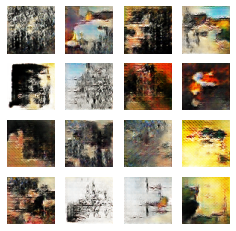

275/275 [==============================] - 63s 224ms/step - d_loss: 0.6937 - g_loss: 0.7005
Epoch 37/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6968 - g_loss: 0.6973

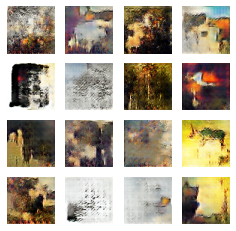

275/275 [==============================] - 64s 228ms/step - d_loss: 0.6970 - g_loss: 0.6972
Epoch 38/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6949 - g_loss: 0.6976

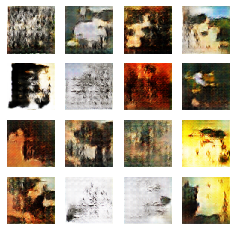

275/275 [==============================] - 66s 235ms/step - d_loss: 0.6951 - g_loss: 0.6979
Epoch 39/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6959 - g_loss: 0.7033

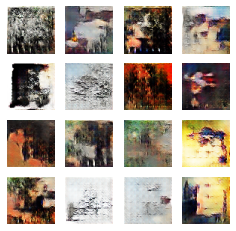

275/275 [==============================] - 65s 232ms/step - d_loss: 0.6958 - g_loss: 0.7039
Epoch 40/50
275/275 [==============================] - ETA: 0s - d_loss: 0.6937 - g_loss: 0.7068

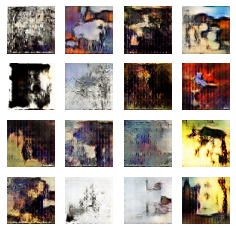

275/275 [==============================] - 66s 235ms/step - d_loss: 0.6937 - g_loss: 0.7068
Epoch 41/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6952 - g_loss: 0.7045

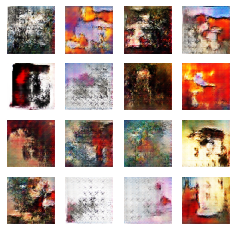

275/275 [==============================] - 66s 234ms/step - d_loss: 0.6953 - g_loss: 0.7049
Epoch 42/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6940 - g_loss: 0.7022

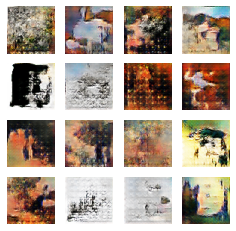

275/275 [==============================] - 65s 231ms/step - d_loss: 0.6941 - g_loss: 0.7023
Epoch 43/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6940 - g_loss: 0.7000

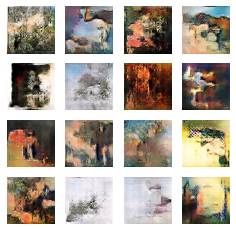

275/275 [==============================] - 64s 227ms/step - d_loss: 0.6940 - g_loss: 0.7002
Epoch 44/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6954 - g_loss: 0.6979

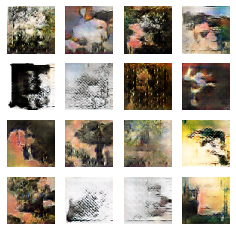

275/275 [==============================] - 66s 236ms/step - d_loss: 0.6956 - g_loss: 0.6980
Epoch 45/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6973 - g_loss: 0.6993

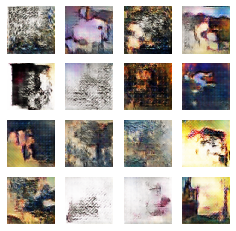

275/275 [==============================] - 66s 237ms/step - d_loss: 0.6974 - g_loss: 0.6993
Epoch 46/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6957 - g_loss: 0.7011

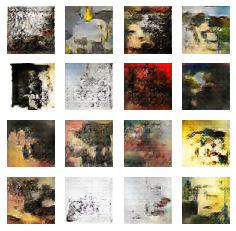

275/275 [==============================] - 68s 243ms/step - d_loss: 0.6958 - g_loss: 0.7015
Epoch 47/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6954 - g_loss: 0.6992

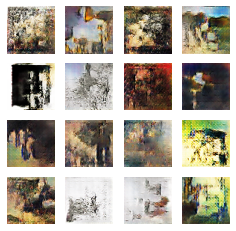

275/275 [==============================] - 67s 239ms/step - d_loss: 0.6953 - g_loss: 0.6994
Epoch 48/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6957 - g_loss: 0.6994

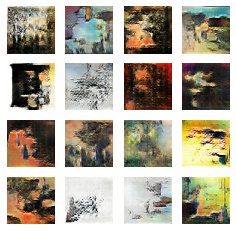

275/275 [==============================] - 67s 240ms/step - d_loss: 0.6958 - g_loss: 0.6995
Epoch 49/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6964 - g_loss: 0.6976

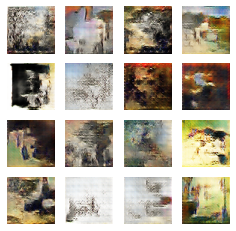

275/275 [==============================] - 67s 239ms/step - d_loss: 0.6964 - g_loss: 0.6978
Epoch 50/50
274/275 [============================>.] - ETA: 0s - d_loss: 0.6952 - g_loss: 0.7020

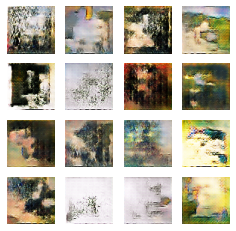

275/275 [==============================] - 67s 239ms/step - d_loss: 0.6951 - g_loss: 0.7020


In [ ]:
NUM_EPOCHS = 50 # number of epochs
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
